# Including proteins from TrEMBL with experimental evidence

In the notebook "swissprot_keywords_go_comparison", we saw that adding GO terms from the GO website to the Swissprot dataset does not provide additional samples. 

The idea for this notebook is the following:

- Filter unreviewed proteins from Uniprot by evidence for protein existence, and only keep those where the existence has been proven at protein level
- Combine this larger dataset with manually curated GO terms

This could give us a larger dataset than curated swissprot, and the data is still based on experimental evidence.

We will also try:

- Include GO-IEA terms
- Compare to keywords

In [128]:
# Downloaded from Uniprot FTP server and unzipped

trembl_file_path = "/home/ad/uniprot_2022_04/uniprot_trembl.fasta"
id_selected_file_path = "~/uniprot_2022_04/idmapping_selected.tab"

In [129]:
with open(trembl_file_path) as trembl_file:
    for line in trembl_file:
        print(line)
        break

>tr|A0A7C4XWK6|A0A7C4XWK6_9EURY 2-isopropylmalate synthase OS=Archaeoglobus sp. OX=1872626 GN=ENS21_07650 PE=3 SV=1



In [130]:
with open(trembl_file_path) as trembl_file:
    for line in trembl_file:
        print(line)
        break

>tr|A0A7C4XWK6|A0A7C4XWK6_9EURY 2-isopropylmalate synthase OS=Archaeoglobus sp. OX=1872626 GN=ENS21_07650 PE=3 SV=1



API Link:

Only existence 1 and no fragments, to save time:

https://rest.uniprot.org/uniprotkb/search?fields=accession%2Creviewed%2Cid%2Cgo_id%2Corganism_id%2Ckeywordid&format=tsv&query=%28%28existence%3A1%29%20AND%20%28fragment%3Afalse%29%29&size=500

With sequences:

In [131]:
from subpred.uniprot_downloader import download_dataset

download_dataset(
    "https://rest.uniprot.org/uniprotkb/search?fields=accession%2Creviewed%2Cid%2Cgo_id%2Corganism_id%2Ckeywordid%2Csequence&format=tsv&query=%28%28existence%3A1%29%20AND%20%28fragment%3Afalse%29%29&size=500",
    "/home/ad/uniprot_2022_04/uniprot_evidence_go_kw.tsv",
)

writing to file /home/ad/uniprot_2022_04/uniprot_evidence_go_kw.tsv...
done.


In [132]:
import pandas as pd
df_uniprot = pd.read_table("/home/ad/uniprot_2022_04/uniprot_evidence_go_kw.tsv", index_col=0)
df_uniprot.head()

,Reviewed,Entry Name,Gene Ontology IDs,Organism (ID),Keyword ID,Sequence
Entry,,,,,,
A0A0C5B5G6,reviewed,MOTSC_HUMAN,GO:0001649; GO:0003677; GO:0005615; GO:0005634...,9606,KW-0238; KW-0496; KW-0539; KW-0892; KW-1185; K...,MRWQEMGYIFYPRKLR
A0A1B0GTW7,reviewed,CIROP_HUMAN,GO:0004222; GO:0005737; GO:0006508; GO:0007155...,9606,KW-0025; KW-0225; KW-0325; KW-1056; KW-0378; K...,MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKS...
A0JNW5,reviewed,UH1BL_HUMAN,GO:0005769; GO:0005829; GO:0042803; GO:0062069,9606,KW-0025; KW-0175; KW-0963; KW-0967; KW-0597; K...,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...
A0JP26,reviewed,POTB3_HUMAN,NaN,9606,KW-0025; KW-0040; KW-0175; KW-1185; KW-0677,MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...
A0PK11,reviewed,CLRN2_HUMAN,GO:0007605; GO:0016021; GO:0032421; GO:0060088...,9606,KW-1003; KW-0966; KW-0209; KW-0225; KW-0325; K...,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...


In [133]:
import re
df_uniprot = df_uniprot[df_uniprot.Sequence.str.match(re.compile("[ACDEFGHIKLMNPQRSTVWY]+"))]


In [134]:
swissprot_proteins = set(df_uniprot[df_uniprot.Reviewed == "reviewed"].index.to_list())
trembl_proteins = set(df_uniprot[df_uniprot.Reviewed == "unreviewed"].index.to_list())

In [135]:
df_uniprot_go = df_uniprot["Gene Ontology IDs"].rename("go_id")
df_uniprot_go = df_uniprot_go[~df_uniprot_go.isnull()]
df_uniprot_go = df_uniprot_go.str.split(";").explode().str.strip()
df_uniprot_go = df_uniprot_go.reset_index(drop=False)
df_uniprot_go.head()

,Entry,go_id
0,A0A0C5B5G6,GO:0001649
1,A0A0C5B5G6,GO:0003677
2,A0A0C5B5G6,GO:0005615
3,A0A0C5B5G6,GO:0005634
4,A0A0C5B5G6,GO:0005739


In [136]:
df_swissprot_go = df_uniprot_go[df_uniprot_go.Entry.isin(swissprot_proteins)].reset_index(drop=True)
df_trembl_go = df_uniprot_go[df_uniprot_go.Entry.isin(trembl_proteins)].reset_index(drop=True)

In [137]:
df_uniprot_kw = df_uniprot["Keyword ID"].rename("kw_ids")
df_uniprot_kw = df_uniprot_kw[~df_uniprot_kw.isnull()]
df_uniprot_kw = df_uniprot_kw.str.split(";").explode().str.strip()
df_uniprot_kw = df_uniprot_kw.reset_index(drop=False)
df_uniprot_kw.head()

,Entry,kw_ids
0,A0A0C5B5G6,KW-0238
1,A0A0C5B5G6,KW-0496
2,A0A0C5B5G6,KW-0539
3,A0A0C5B5G6,KW-0892
4,A0A0C5B5G6,KW-1185


In [138]:
df_swissprot_kw = df_uniprot_kw[df_uniprot_kw.Entry.isin(swissprot_proteins)].reset_index(drop=True)
df_trembl_kw = df_uniprot_kw[df_uniprot_kw.Entry.isin(trembl_proteins)].reset_index(drop=True)
df_trembl_kw.head()

,Entry,kw_ids
0,A0A0A0MQU7,KW-0010
1,A0A0A0MQU7,KW-0238
2,A0A0A0MQU7,KW-0371
3,A0A0A0MQU7,KW-0539
4,A0A0A0MQU7,KW-1267


In [139]:
from subpred.go_utils import GeneOntology
go = GeneOntology("../data/raw/ontologies/go.owl")

In [140]:
transmembrane_transport_descendants = go.get_descendants(
    go.get_identifier("transmembrane transporter activity")
)
amino_acid_descendants = go.get_descendants(
    go.get_identifier("amino acid transmembrane transporter activity")
)
carbohydrate_descendants = go.get_descendants(
    go.get_identifier("carbohydrate transmembrane transporter activity")
)
sugar_descendants = go.get_descendants(
    go.get_identifier("sugar transmembrane transporter activity")
)
ion_descendants = go.get_descendants(
    go.get_identifier("ion transmembrane transporter activity")
)

### GO dataset from website (No-IEA)

In [141]:
df_go_noiea = pd.read_table(
    "/home/ad/gene_ontology/goa_uniprot_all_noiea.gaf.gz",
    header=None,
    names=[
        "db",
        "db_object_id",
        "db_object_symbol",
        "qualifier",
        "go_id",
        "db_reference",
        "evidence_code",
        "with_or_from",
        "aspect",
        "db_object_name",
        "db_object_synonym",
        "db_object_type",
        "taxon",
        "date",
        "assigned_by",
        "annotation_extension",
        "gene_product_form_id",
    ],
)
df_go_noiea.head()

,db,db_object_id,db_object_symbol,qualifier,go_id,db_reference,evidence_code,with_or_from,aspect,db_object_name,db_object_synonym,db_object_type,taxon,date,assigned_by,annotation_extension,gene_product_form_id
0,UniProtKB,Q5R8N4,VPS35L,located_in,GO:0005768,GO_REF:0000024,ISS,UniProtKB:Q7Z3J2,C,VPS35 endosomal protein-sorting factor-like,VPS35L,protein,taxon:9601,20190110,UniProt,NaN,NaN
1,UniProtKB,Q5R8N4,VPS35L,involved_in,GO:0032456,GO_REF:0000024,ISS,UniProtKB:Q7Z3J2,P,VPS35 endosomal protein-sorting factor-like,VPS35L,protein,taxon:9601,20190114,UniProt,NaN,NaN
2,UniProtKB,Q87UX2,blc,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Outer membrane lipoprotein Blc,blc|PSPTO_5170,protein,taxon:223283,20061207,JCVI,NaN,NaN
3,UniProtKB,Q87UX2,blc,involved_in,GO:0008150,GO_REF:0000015,ND,NaN,P,Outer membrane lipoprotein Blc,blc|PSPTO_5170,protein,taxon:223283,20061207,JCVI,NaN,NaN
4,UniProtKB,C8VDI1,AN11006,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Uncharacterized protein AN11006,AN11006,protein,taxon:227321,20200401,AspGD,NaN,NaN


In [142]:
df_go_noiea = df_go_noiea[(df_go_noiea.db == "UniProtKB") & (df_go_noiea.qualifier == "enables") & (df_go_noiea.aspect == "F")]
df_go_noiea = df_go_noiea[["db_object_id", "go_id"]]
df_go_noiea = df_go_noiea[df_go_noiea.db_object_id.isin(df_uniprot.index)]
df_go_noiea

,db_object_id,go_id
14,Q93AM0,GO:0008047
39,Q9A9T8,GO:0005515
63,P04014,GO:0003678
64,P04014,GO:0003677
65,P04014,GO:0003677
...,...,...
308858,P00180,GO:0005515
308871,A1C3L9,GO:0016757
308872,A1C3L9,GO:0016757
308873,A1C3L9,GO:0005515


### Go dataset (IEA)

In [143]:
df_go_iea = pd.read_table("/home/ad/gene_ontology/goa_sp_iea_mf_enables.tsv", header=None, names=["Uniprot", "go_id", "evidence_code"])

In [144]:
df_go_iea = df_go_iea[df_go_iea.Uniprot.isin(df_uniprot.index)]

In [146]:
from venn import venn
import matplotlib.pyplot as plt
def venn_plot_go(go_set:set):
    tmt_swissprot = set(df_swissprot_go[df_swissprot_go.go_id.isin(go_set)].Entry.to_list())
    tmt_uniprot = set(df_uniprot_go[df_uniprot_go.go_id.isin(go_set)].Entry.to_list())
    tmt_go_noiea = set(df_go_noiea[df_go_noiea.go_id.isin(go_set)].db_object_id.to_list())
    tmt_go_iea = set(df_go_iea[df_go_iea.go_id.isin(go_set)].Uniprot.to_list())
    venn({"go-swissprot":tmt_swissprot, "go-uniprot":tmt_uniprot, "go-noiea": tmt_go_noiea, "go-iea":tmt_go_iea})

### Transmembrane transporters

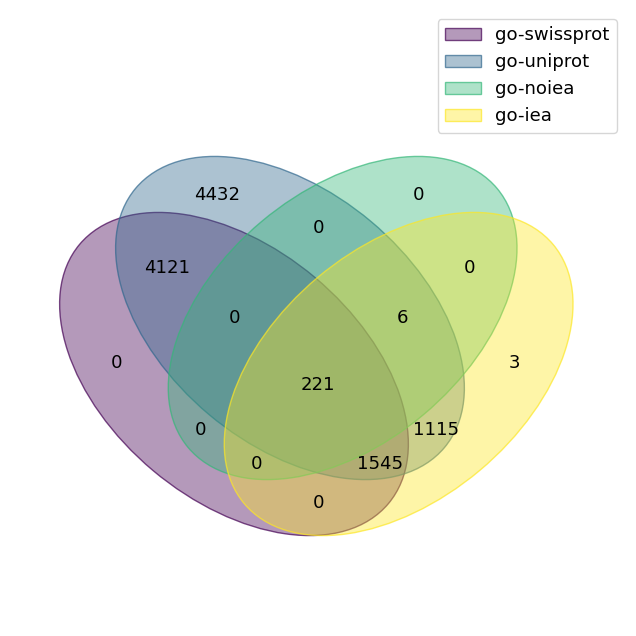

In [150]:
venn_plot_go(transmembrane_transport_descendants)

### Sugar

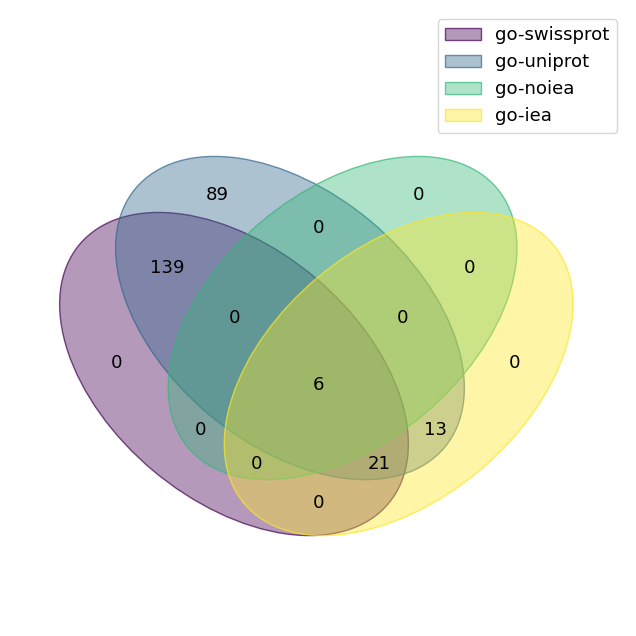

In [151]:
venn_plot_go(sugar_descendants)

### Carbohydrate

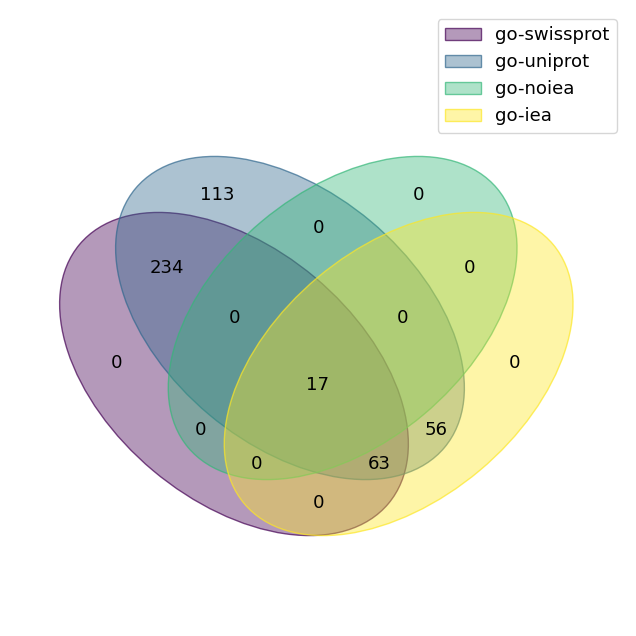

In [152]:
venn_plot_go(carbohydrate_descendants)

### Amino acid

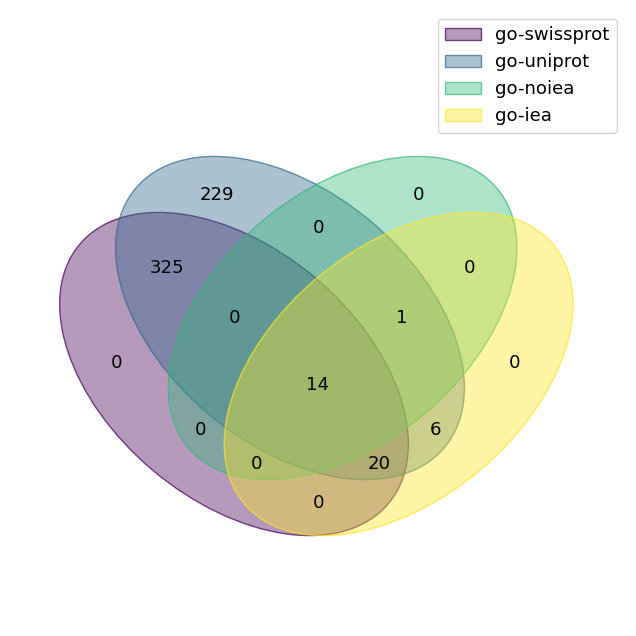

In [154]:
venn_plot_go(amino_acid_descendants)

## Keywords

Transport (KW-0813)
Transmembrane (KW-0812)